# Assignment 2

In [2]:
# imports

import seaborn as sns
import pandas as pd
import random as random 
import numpy as np

## Task 5 of Assignment 1:


In [ ]:
# Copying your code ....

allRolls5Dice = lambda : [[a+1,b+1,c+1,d+1,e+1] for a in range (6)\
                                                for b in range (6)\
                                                for c in range (6)\
                                                for d in range (6)\
                                                for e in range (6)]

allRollsNDices = lambda n: [[a+1]+smallerRoll for a in range(6) for smallerRoll in allRollsNDices(n-1)] if n > 1 else [[a+1] for a in range(6)]

isGenerala = lambda roll: True if len(set(roll)) == 1 else False
notServedGeneralas = [roll for roll in allRolls5Dice() if not isGenerala(roll)]

p_served_generala = len([roll for roll in allRolls5Dice() if isGenerala(roll)]) / float(len(allRolls5Dice()))
print(p_served_generala)
waysOfChooseFromFiveDice = 5 + 5*4 + 5*4*3 + 5*4*3*2 + 5*4*3*2*1

unUnsefulPickUpsCount = 0
usefulPickUps = []
for notServedGenerala in notServedGeneralas:
    for diceType in set(notServedGenerala):
        usefulPickUp = [dice for dice in notServedGenerala if dice == diceType]
        usefulPickUps.append(usefulPickUp)
        
        unUnsefulPickUpsCount += waysOfChooseFromFiveDice - len(usefulPickUp)
        
print (len (usefulPickUps), unUnsefulPickUpsCount)

generalaCountAfterReroll = 0
notGeneralaCountAfterReroll = 0
for usefulPickUp in usefulPickUps:
    for reroll in allRollsNDices(5-len(usefulPickUp)):
        if isGenerala(usefulPickUp+reroll): generalaCountAfterReroll += 1
        else: notGeneralaCountAfterReroll += 1
        
print (generalaCountAfterReroll, notGeneralaCountAfterReroll)

p_generada_after_two_rolls = p_served_generala + ( generalaCountAfterReroll / (generalaCountAfterReroll+notGeneralaCountAfterReroll + unUnsefulPickUpsCount) )
print (p_generada_after_two_rolls)

# playing with no strategy i just add up the probabilty of another reroll
#(we have again the same number of unuseful and useful pickups and the probability of getting generala 
# of the useful pickups is the same as before)
p_generala_after_three_rolls = p_generada_after_two_rolls + (generalaCountAfterReroll/(generalaCountAfterReroll+notGeneralaCountAfterReroll +unUnsefulPickUpsCount))
print(p_generala_after_three_rolls)


0.0007716049382716049
27900 9028650


## Assignment 2: ATP production 



The function has following form: $$ f(x) = a * proteins + b * carbohydrates + c * fats + \epsilon $$


In [8]:
dataframe = pd.read_csv("diet_and_atp.tsv", header=[0], sep="\t")


For the problem i'm going to create a MCMC model


In [9]:
# First i tried to approximate all the three variables at the same time but as they didn't converge 
#(probably because in each iteration all of the values are going to get a new random candidate --> the three variables
# together cannot converge simultaneously)
# i decided to approximate the variable "a" first, then variable "b" and then the variable "c"
# These approximations REALLY depend on the chosen start value...because i set the values "b " and "c" fixed 
# while approximating value "a"

iterations = 1000
currentPosition = [1,1,1] # this is my initial guess of the 3-dimensional data (a, b, c) 
allStepsA = [] # record of step at point A
allPositionsA = [] # record of all position which will be the posterior distribution

for i in range (iterations) :
    # from each current position we have to decide for some random close point for variable A, 
    # the other points stay the same
    stepA = [random.uniform(0,1) - 0.5,0,0] # we can move maximal 0.5 in each direction in each dimension
    # now we create the candidate for the next step
    candidateA = [x + y for x, y in zip(currentPosition, stepA)] 
    #print("candidate:",candidate)
    
    # function that calculates with the current variables the probability that the prediction is correct 
    def getPredictionProb (position) :
        # save the rows that the prediction is accurate 
        accuratePredictions = []
        for i,row in dataframe.iterrows() :
            # prediction with the given formula: a*proteins + b*carbohydrates + c*fats - ATP = Error
            # used Error function: mean-squared error
            # the threshold is 0.5
            if pow(row[0]*position[0] + row[1]*position[1] + row[2]*position[2] - row[3],2) < 0.5 :
                accuratePredictions.append(row)
        return len(accuratePredictions)/float(len(dataframe))
    
    # the candidate has to be evaluated if to go forward or not 
    
    pCurrentPosition = getPredictionProb(currentPosition)
    #print("pCurrent: ", pCurrentPosition)
    
    pCandidateA = getPredictionProb(candidateA)
    #print("pCandidate: ", pCandidateA)
    
    # If the probability for the prediction of the candidate is better, accept
    if pCandidateA > pCurrentPosition:
        currentPosition = candidateA
    else:
        # if not, randomly accepted
        randomNum = random.uniform(0,1)
        #print(pCandidate)
        #print(pCurrentPosition)
        if randomNum <= pCandidateA/ pCurrentPosition:
            currentPosition = candidateA
        #print ("here: ",currentPosition, step)
    
    # I record my step and where I'm standing
    allPositionsA.append(currentPosition)
    allStepsA.append(stepA)
#print(allPositionsA)
    

In [10]:
# calculate mean of variable a and use it for getting the values of b and c
finalA = np.sum([elem[0] for elem in allPositionsA])/len(allPositionsA)
print(finalA)

2.0229832725703387


In [11]:
# doing the same steps for parameter b

currentPosition = [finalA,1,1] # this is my initial guess of the 3-dimensional data (a, b, c) 
allStepsB = [] # record of step at each point 
allPositionsB = [] # record of all position which will be the posterior distribution
for i in range (iterations) :
    # from each current position we have to decide for some random close points 
    stepB = [0,random.uniform(0,1) - 0.5,0] # we can move maximal 0.5 in each direction in each dimension
    # now we create the candidate for the next step
    candidateB = [x + y for x, y in zip(currentPosition, stepB)] 
    #print("candidate:",candidate)
    
    def getPredictionProb (position) :
        # save the rows that the prediction is accurate 
        accuratePredictions = []
        for i,row in dataframe.iterrows() :
            # prediction with the given formula: a*proteins + b*carbohydrates + c*fats - ATP = Error
            if pow(row[0]*position[0] + row[1]*position[1] + row[2]*position[2] - row[3],2) < 0.5 :
                accuratePredictions.append(row)
        return len(accuratePredictions)/float(len(dataframe))
    
    # the candidate has to be evaluated if to go forward or not 
    
    pCurrentPosition = getPredictionProb(currentPosition)
    #print("pCurrent: ", pCurrentPosition)
    
    pCandidateB = getPredictionProb(candidateB)
    #print("pCandidate: ", pCandidateB)
    
    # If the new step is better, I always accept
    if pCandidateB > pCurrentPosition:
        currentPosition = candidateB
    else:
        # if not, randomly accepted
        randomNum = random.uniform(0,1)
        #print(pCandidate)
        #print(pCurrentPosition)
        if randomNum <= pCandidateB/ pCurrentPosition:
            currentPosition = candidateB
        #print ("here: ",currentPosition, step)
    
    # I record my step and where I'm standing
    allPositionsB.append(currentPosition)
    allStepsB.append(stepB)
    
    # calculate mean of variable a and use it for getting the values of b and c
    
finalB = np.sum([elem[1] for elem in allPositionsB])/len(allPositionsB)
print(finalB)

0.4986289630034641


In [12]:
# doing the same steps for parameter c

currentPosition = [finalA,finalB,1] # this is my initial guess of the 3-dimensional data (a, b, c) 
allStepsC = [] # record of step at each point 
allPositionsC = [] # record of all position which will be the posterior distribution
for i in range (iterations) :
    # from each current position we have to decide for some random close points 
    stepC = [0,0,random.uniform(0,1) - 0.5] # we can move maximal 0.5 in each direction in each dimension
    # now we create the candidate for the next step
    candidateC = [x + y for x, y in zip(currentPosition, stepC)] 
    #print("candidate:",candidate)
    
    def getPredictionProb (position) :
        # save the rows that the prediction is accurate 
        accuratePredictions = []
        for i,row in dataframe.iterrows() :
            # prediction with the given formula: a*proteins + b*carbohydrates + c*fats - ATP = Error
            if pow(row[0]*position[0] + row[1]*position[1] + row[2]*position[2] - row[3],2) < 0.5 :
                accuratePredictions.append(row)
        return len(accuratePredictions)/float(len(dataframe))
    
    # the candidate has to be evaluated if to go forward or not 
    
    pCurrentPosition = getPredictionProb(currentPosition)
    #print("pCurrent: ", pCurrentPosition)
    
    pCandidateC = getPredictionProb(candidateC)
    #print("pCandidate: ", pCandidateC)
    
    # If the new step is better, I always accept
    if pCandidateC > pCurrentPosition:
        currentPosition = candidateC
    else:
        # if not, randomly accepted
        randomNum = random.uniform(0,1)
        #print(pCandidate)
        #print(pCurrentPosition)
        if randomNum <= pCandidateC/ pCurrentPosition:
            currentPosition = candidateC
        #print ("here: ",currentPosition, step)
    
    # I record my step and where I'm standing
    allPositionsC.append(currentPosition)
    allStepsC.append(stepC)
    
    # calculate mean of variable a and use it for getting the values of b and c
    
finalC = np.sum([elem[2] for elem in allPositionsC])/len(allPositionsC)
print(finalC)

5.474131629989476


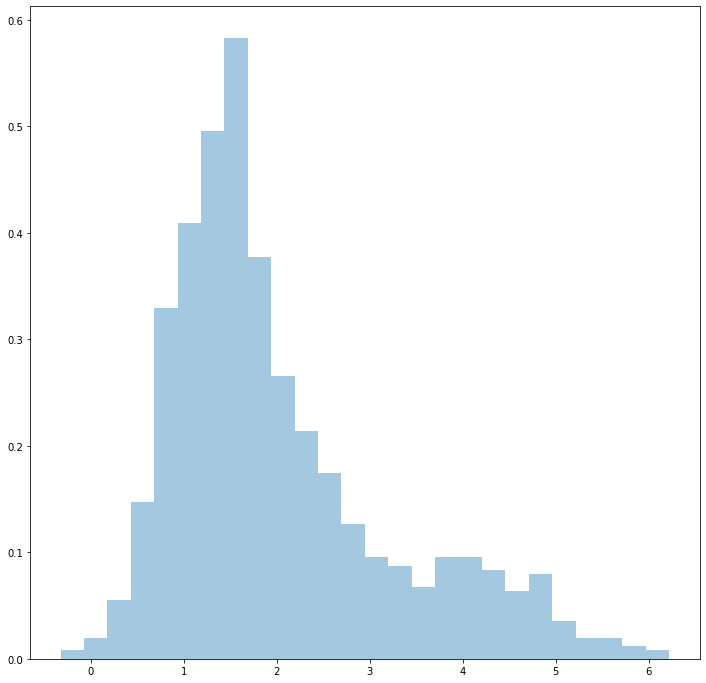

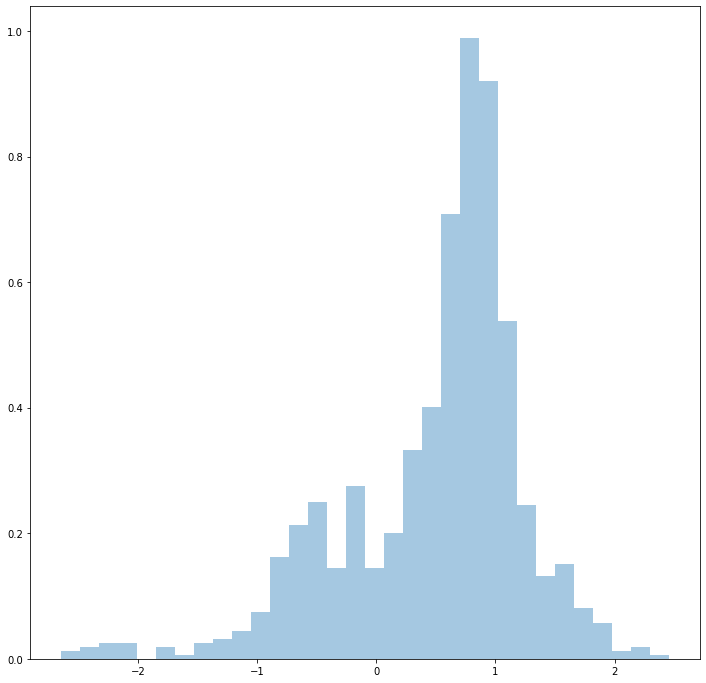

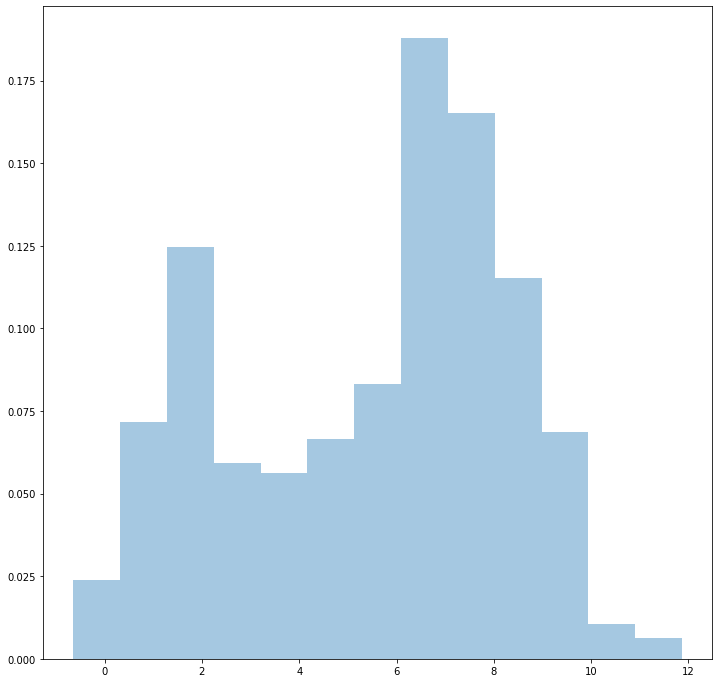

In [13]:
# Plotting the likelihood function for each variable that im inferring separately
import matplotlib.pyplot as plt  
fig=plt.figure(figsize=(12, 12))
sns.distplot([elem[0] for elem in allPositionsA], kde=False, label="my guess after %s iterations" % iterations, norm_hist=True)


fig=plt.figure(figsize=(12, 12))
sns.distplot([elem[1] for elem in allPositionsB], kde=False, label="my guess after %s iterations" % iterations, norm_hist=True)
    
fig=plt.figure(figsize=(12, 12))
sns.distplot([elem[2] for elem in allPositionsC], kde=False, label="my guess after %s iterations" % iterations, norm_hist=True)
    

In [14]:
# my final variables would be finalA, finalB and finalC 
# check the resulting error:

print(getPredictionProb([finalA,finalB,finalC]))
sum = 0
for i,row in dataframe.iterrows() :
        # prediction with the given formula: a*proteins + b*carbohydrates + c*fats - ATP = Error
        sum = sum + pow(row[0]*finalA + row[1]*finalB + row[2]*finalC - row[3], 2)
print(sum/len(dataframe))

0.3333333333333333
2.0476825373717906
